In [1]:
import theano

Can not use cuDNN on context None: Disabled by dnn.enabled flag
Mapped name None to device cuda: GeForce GT 750M (0000:01:00.0)


In [2]:
from __future__ import print_function

In [3]:
import os

import numpy as np

from matplotlib.pyplot import imread, imshow, figure, axis, xlabel, ylabel, ylim, xlim
from keras.models import Sequential, model_from_yaml
from keras.layers import Dense, Dropout, Flatten, Convolution2D, AveragePooling2D
from keras.utils import np_utils
from keras.datasets import mnist

/Users/afetisov/anaconda/envs/theano_2.7/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using Theano backend.


### Data preparation

In [4]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

x_train = X_train.astype("float32").reshape(X_train.shape[0], 28, 28, 1) # "channels last" format
x_train /= 255 # puts everything into [0, 1] range

x_test = X_test.astype("float32").reshape(X_test.shape[0], 28, 28, 1)
x_test /= 255

y_train = np_utils.to_categorical(Y_train, 10) # OHE, basically
y_test = np_utils.to_categorical(Y_test, 10)

### Model

1. From the dataset description we know that the images are centered around the center of mass of the pixels. Hence, it's unlikely that there's any information at the edges, so we don't need any initial padding
2. Three sequential convolutional layers of 32 filters each extract features and reduce dimensions a bit
3. AveragePooling2D layer, well, averages values in every 2x2 window
4. Flattening layer removes any spatial information and prepares data to be consumed by the fully-connected layer
5. A dense layer with a dropout learns from extracted features (and, hopefully, doesn't overfit)
6. Finally, the dense layer with 10 softmax outputs predicts a class

In [5]:
# for the sake of reproducibility
np.random.seed(0)

model = Sequential()
model.add(Convolution2D(filters=32, kernel_size=4, activation="relu", input_shape=(28, 28, 1)))
model.add(Convolution2D(filters=32, kernel_size=3, activation="relu"))
model.add(Convolution2D(filters=32, kernel_size=2, activation="relu"))
model.add(AveragePooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(units=128, activation="relu"))
model.add(Dropout(rate=0.5))
model.add(Dense(units=10, activation="softmax"))

model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["categorical_accuracy"])
model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1, validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)
print("\nTest loss: {}\nTest accuracy: {}".format(score[0], score[1])) 

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 311s 5ms/step - loss: 0.1956 - categorical_accuracy: 0.9405 - val_loss: 0.0450 - val_categorical_accuracy: 0.9852
Epoch 2/10
60000/60000 [==============================] - 311s 5ms/step - loss: 0.0799 - categorical_accuracy: 0.9758 - val_loss: 0.0314 - val_categorical_accuracy: 0.9891
Epoch 3/10
60000/60000 [==============================] - 320s 5ms/step - loss: 0.0599 - categorical_accuracy: 0.9823 - val_loss: 0.0275 - val_categorical_accuracy: 0.9904
Epoch 4/10
60000/60000 [==============================] - 315s 5ms/step - loss: 0.0489 - categorical_accuracy: 0.9853 - val_loss: 0.0286 - val_categorical_accuracy: 0.9901
Epoch 5/10
60000/60000 [==============================] - 309s 5ms/step - loss: 0.0405 - categorical_accuracy: 0.9875 - val_loss: 0.0283 - val_categorical_accuracy: 0.9909
Epoch 6/10
60000/60000 [==============================] - 313s 5ms/step - loss: 0.0366 - c

### Classification results

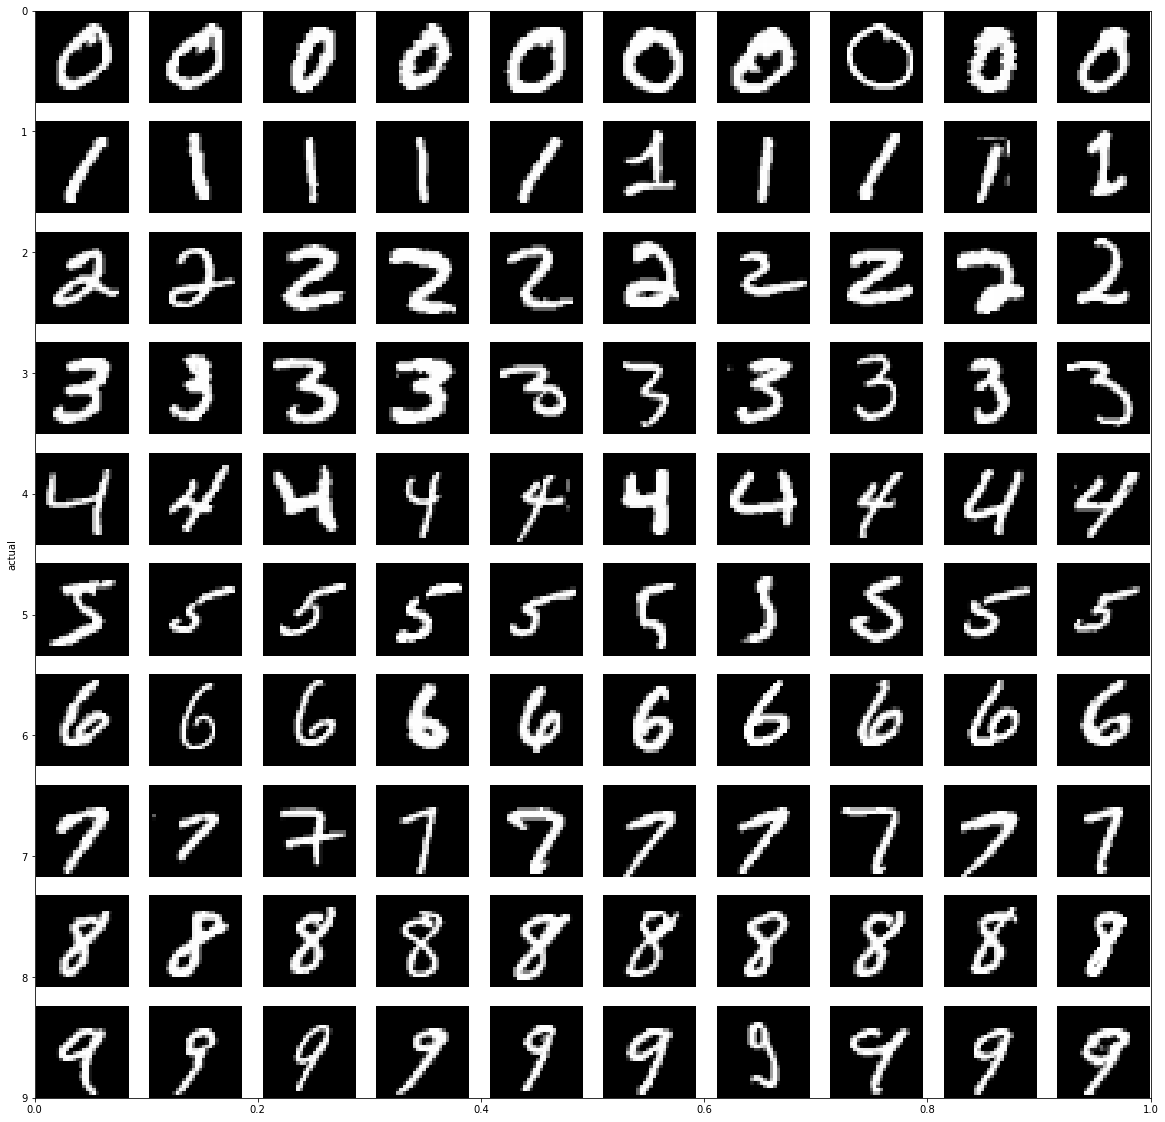

In [6]:
fig = figure(figsize=(20, 20))
ylabel("actual")
ylim((9, 0))
counts = {i:0 for i in range(10)}

for i in range(len(x_train)):
    if all([x >= 10 for x in counts.values()]):
        break
    
    predicted = model.predict(x_train[i].reshape(1, 28, 28, 1)).argmax()
    actual = y_train[i].argmax()
    if predicted != actual:
        continue
        
    count = counts[predicted]
    if count >= 10:
        continue
    
    fig.add_subplot(10, 10, 1 + 10 * predicted + count)
    imshow(X_train[i], cmap="Greys_r")
    axis("off")
    counts[predicted] += 1

### Classification errors

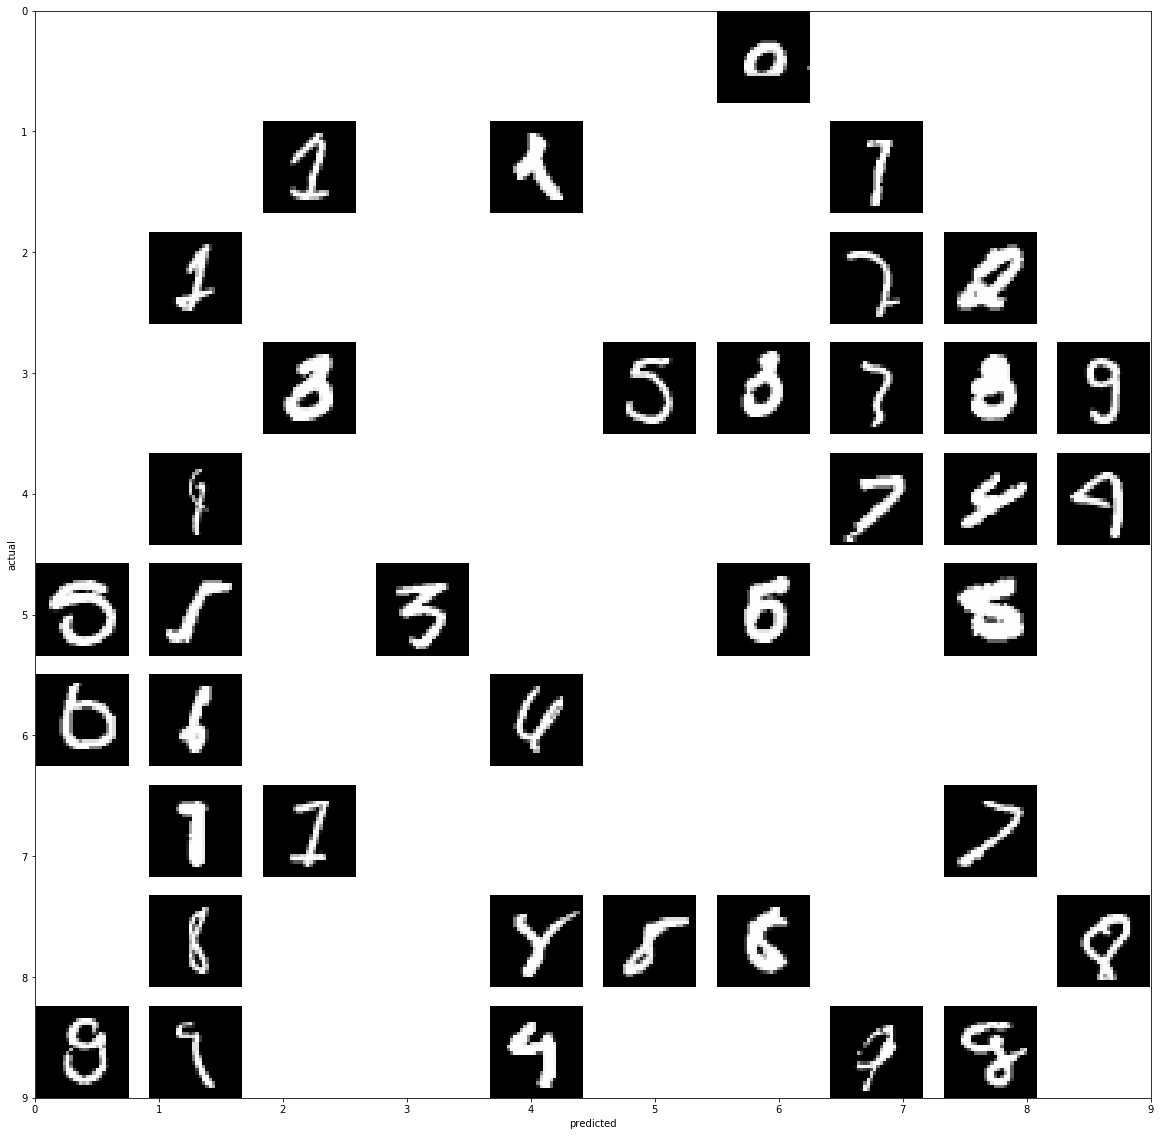

In [7]:
fig = figure(figsize=(20, 20))
ylabel("actual")
xlabel("predicted")
ylim((9, 0))
xlim((0, 9))
counts = {i:[0]*10 for i in range(10)}

for i in range(len(x_train)):
    if all([sum(x) >= 10 for x in counts.values()]):
        break
    
    predicted = model.predict(x_train[i].reshape(1, 28, 28, 1)).argmax()
    actual = y_train[i].argmax()
    if predicted == actual:
        continue
        
    act_to_pred = counts[actual]
    if act_to_pred[predicted] > 0:
        continue
    
    fig.add_subplot(10, 10, 1 + 10 * actual + predicted)
    imshow(X_train[i], cmap="Greys_r")
    axis("off")
    counts[actual][predicted] += 1

### Model persistence

In [8]:
with open("model.yaml", "w") as f:
    f.write(model.to_yaml())
model.save_weights("weights.h5")

In [9]:
with open("model.yaml", "r") as f:
    restored_model = model_from_yaml(f.read())
restored_model.load_weights("weights.h5")

### Custom data

In [10]:
data_folder = "data"

def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

images = {}
for f in [f for f in os.listdir(data_folder) if f[0] != "."]:
    image = rgb2gray(imread(os.path.join(data_folder, f)))    
    images[f] = image

In [11]:
print("Predicted\tFilename\tCorrect")
for k in images:
    x = images[k].astype("float32").reshape(1, 28, 28, 1)
    x /= 255
    pred = restored_model.predict(x).argmax()
    print("{}\t\t{}\t\t{}".format(pred, k, pred == int(os.path.splitext(k)[0])))

Predicted	Filename	Correct
0		05.jpg		False
2		2.jpg		True
2		07.jpg		False
5		5.jpg		True
2		01.jpg		False
2		03.jpg		False
8		7.jpg		False
6		6.jpg		True
8		8.jpg		True
8		09.jpg		False
2		0.jpg		False
2		4.jpg		False
6		00.jpg		False
2		02.jpg		True
8		3.jpg		False
4		1.jpg		False
8		08.jpg		True
6		06.jpg		True
4		04.jpg		True
2		9.jpg		False


Looks like this NN isn't that good after all. Or something's terribly wrong with my handwriting skills. Or it's the fact that these images weren't properly centered around their pixel mass centers (and it's again the reason №1, because that means that NN relies on it too much).